In [356]:
import pandas as pd
import numpy as np
import torch
from sklearn import linear_model
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random
import os
import time
from ta import add_all_ta_features

In [357]:
'''for f in os.listdir('stocks'):
    if os.path.getsize('stocks/'+f)<7000:
        os.remove('stocks/'+f)
for f in os.listdir('etfs'):
    if os.path.getsize('etfs/'+f)<7000:
        os.remove('etfs/'+f)'''

"for f in os.listdir('stocks'):\n    if os.path.getsize('stocks/'+f)<7000:\n        os.remove('stocks/'+f)\nfor f in os.listdir('etfs'):\n    if os.path.getsize('etfs/'+f)<7000:\n        os.remove('etfs/'+f)"

In [358]:
l1=os.listdir('stocks')
l2=os.listdir('etfs')
device=torch.device('cuda:0')

In [359]:
def lin_reg(df): #feature neutralization to 1st order
    reg = linear_model.LinearRegression()
    reg.fit(df[:,6:],df[:,:5])
    return reg.predict(df[:,6:])

In [360]:
def generate(path):
    df=pd.read_csv(path).filter(['Open','High','Low','Close','Adj Close','Volume'])
    df=df.dropna()
    df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    df=np.array(df)
    neutralized = lin_reg(df)
    df[:,:5] -= neutralized
    df=df[:-1]-df[1:]
    transprices=RobustScaler().fit(df[:,:5])
    df[:,:5]=transprices.transform(df[:,:5])
    maxprice=np.max(np.abs(df[:,:5]))
    maxvol=np.max(np.abs(df[:,5]))
    df[:,:5] /= maxprice
    df[:,5] /= maxvol
    for x in range(6,df.shape[1]):
        transinc=RobustScaler().fit(df[:,x].reshape(-1,1))
        df[:,x]=transinc.transform(df[:,x].reshape(-1,1))[:,0] #transform indicator
    df[:,6:] /= np.max(np.abs(df[:,6:]),0)
    np.nan_to_num(df,False,0,1,-1)
    return df,maxprice,maxvol,transprices,neutralized

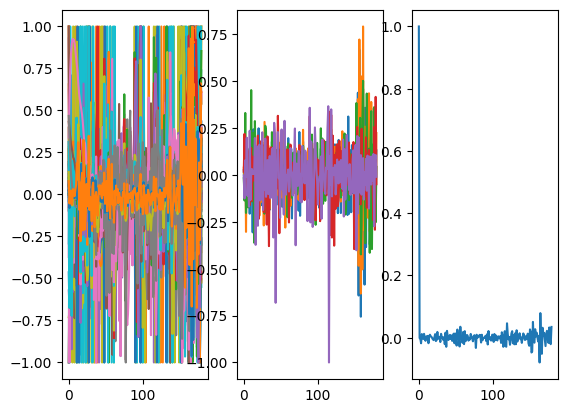

In [361]:
random.shuffle(l1)
random.shuffle(l2)
test_path = 'etfs/'+l2[0]
df,maxprice,maxvol,transa,neutralized = generate(test_path)
fig,ax = plt.subplots(1,3)
ax[0].plot(df)
ax[1].plot(df[:,:5])
ax[2].plot(df[:,5])
plt.show()

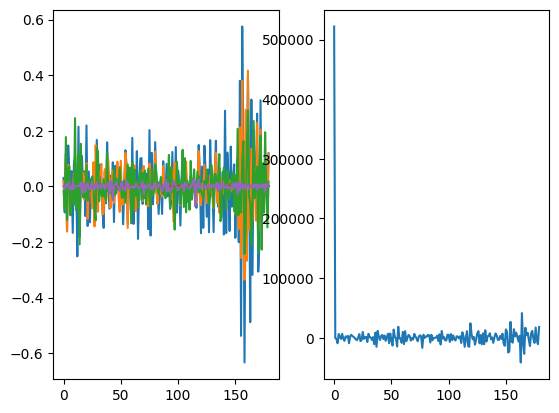

In [362]:
#restoring
def restorePreds(d,maxprice,maxvol,transa):
    df=d.copy()
    df[:,:5]=transa.inverse_transform(df[:,:5]*maxprice)
    df[:,5]=df[:,5]*maxvol
    return df
df=restorePreds(df,maxprice,maxvol,transa)
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(df[:,5])
plt.show()

In [363]:
def create(dataset,lback,lforward=1):
    X,y=[],[]
    for i in range(len(dataset)-lback-lforward+1):
        X.append(np.array(dataset[i:i+lback]))
        y.append(np.array(dataset[i+1:i+lback+lforward]))
    return torch.tensor(np.array(X)).float(),torch.tensor(np.array(y)).float()

In [364]:
lback=50
X_train,y_train=create(df,lback=lback)

PHASE 1a1: LSTM PREDICTION

In [365]:
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm=nn.LSTM(input_size=92,hidden_size=200,num_layers=2,dropout=0.1,batch_first=True)
        self.l1=nn.Linear(200,92)
    def forward(self,x):
        x,_=self.lstm(x)
        x=self.l1(x)
        return x

In [366]:
model=LSTMModel()
model.to(device)

LSTMModel(
  (lstm): LSTM(92, 200, num_layers=2, batch_first=True, dropout=0.1)
  (l1): Linear(in_features=200, out_features=92, bias=True)
)

In [367]:
def l2loss(y_pred,y):
    return torch.mean(torch.square(y_pred-y))

In [368]:
def signloss(y_pred,y):
    #return torch.ceil(-y_pred[:,:,:5]*y[:,:,:5])
    return -torch.mean(torch.clip(y[:,:,:5]*y_pred[:,:,:5],0)*torch.abs(y[:,:,:5]))

In [369]:
def extloss(y_pred,y):
    return torch.square(torch.mean(torch.abs(y)-torch.abs(y_pred)))

In [370]:
def lstmloss(y_pred,y):
    l2 = l2loss(y_pred,y)*3
    sign = signloss(y_pred,y)
    ext = extloss(y_pred,y)
    #return torch.clip(2*(l2+sign),max=.5)
    return torch.clip(l2*(1+sign+ext),max=.5)

In [371]:
def train(n_epochs,dl,lforward=1):
    optimizer=torch.optim.Adam(model.parameters(),lr=1e-3/lforward)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5/lforward, max_lr=1e-3/lforward,step_size_up=10000,mode="triangular2",cycle_momentum=False)
    for i in range(n_epochs):
        for X,y in dl:
            y = y.to(device)
            logits = 0
            y_pred = model(X.to(device))
            logits += lstmloss(y_pred,y[:,:lback])
            for j in range(1,lforward):
                y_pred = model(y_pred)
                logits += lstmloss(y_pred,y[:,j:j+lback])
            logits = logits/lforward
            optimizer.zero_grad()
            logits.backward()
            optimizer.step()
            scheduler.step()
    print(logits)
    torch.save(model.state_dict(),'lstmmodel.pt')

In [372]:
model.train()
for i in l2[:100]:
    a='etfs/'+i
    df,_,_,_,_=generate(a)
    X_train,y_train=create(df,lback=lback)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(1,dl)

tensor(0.1011, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0618, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0598, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0740, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0880, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0877, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0708, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0510, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1691, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0460, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0442, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0670, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0454, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0927, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0532, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0502, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0536, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0506, device='cuda:0', grad_fn=<DivBack

PHASE 1a2: LSTM STAGE 2 (>1 PREDICTION)

In [373]:
'''model.train()
random.shuffle(l1);random.shuffle(l2)
for i in l2[:100]:
    a='etfs/'+i
    df,_,_,_,_=generate(a)
    X_train,y_train=create(df,lback=lback,lforward=10)
    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)
    train(5,dl,10)'''

"model.train()\nrandom.shuffle(l1);random.shuffle(l2)\nfor i in l2[:100]:\n    a='etfs/'+i\n    df,_,_,_,_=generate(a)\n    X_train,y_train=create(df,lback=lback,lforward=10)\n    dl=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train,y_train),shuffle=True,batch_size=64)\n    train(5,dl,10)"

In [374]:
model.load_state_dict(torch.load('lstmmodel.pt'))

<All keys matched successfully>

In [375]:
test_path='etfs/'+random.choice(l2)
print(test_path)

etfs/VOE.csv


In [376]:
model.eval() #NOT EVAL IN FINAL PREDICTIONS
df,a,b,transprices,neutralized = generate(test_path)
X_test,y_test = create(df, lback=lback)
dl = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), shuffle=False, batch_size=1)
qwer = True
for X,y in dl:
    if qwer:
        predicted = list(X.detach().numpy()[0])
        qwer = False
    predicted.append(model(X.to(device))[0][-1].detach().cpu().numpy())

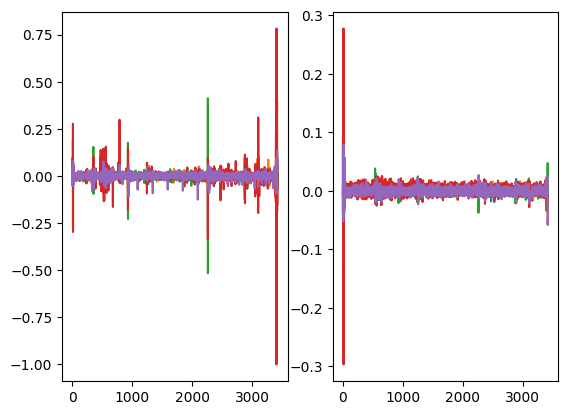

In [377]:
fig,ax=plt.subplots(1,2)
ax[0].plot(df[:,:5])
ax[1].plot(np.array(predicted)[:,:5])
plt.show()

(3423, 6)
[array([  50.65000153,   50.68000031,   50.65000153,   50.66999817,
         38.22121811, 3400.        ])]


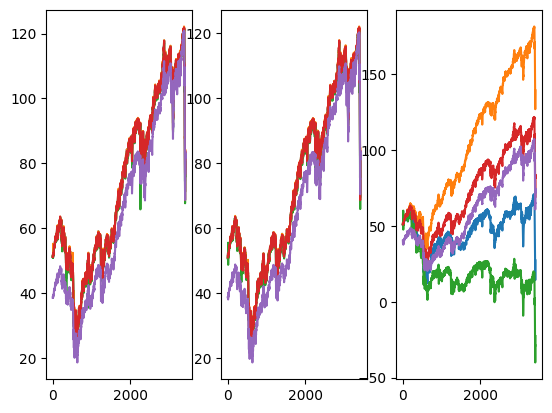

In [378]:
test_data=np.array(pd.read_csv(test_path).filter(['Open','High','Low','Close','Adj Close','Volume']))
print(test_data.shape)
fig,ax=plt.subplots(1,3)
ax[0].plot(test_data[1:,:5]) # original

predicted=np.array(predicted)
predicted=restorePreds(predicted,a,b,transprices)
test2=predicted[:,:5]+neutralized[:-1]
ax[1].plot(test2[1:-1]) # check that the transforms are correct, consider this 1 day preds

testult=[test_data[0]]
print(testult)
for i in range(predicted.shape[0]):
    testult.append(np.sum(predicted[:i+1],axis=0)[:6])
testult = np.array(testult)[:-1,:5]+neutralized[:-1]
ax[2].plot(np.array(testult)[1:-1,:5]) # results, cumulative error

In [379]:
def test_prep(arr):
    arr /= np.max(np.abs(arr))
    arr = arr[:-1]-arr[1:]
    return arr
test_data = test_prep(test_data[:-1,:5]) #original
test2 = test_prep(test2[:,:5]) #preds

pp=np.sum(np.ceil(test_data))
pn=np.sum(np.ceil(-test_data))
p=np.sum(np.ceil(test2))
n=np.sum(np.ceil(-test2))
tp=np.sum(np.ceil(test_data)*np.ceil(test2))
tn=np.sum(np.ceil(-test_data)*np.ceil(-test2))
recall=tp/p
precision=tp/pp
print('recall: ',recall)
print('precision: ',precision)
print('acc: ',(tp+tn)/(p+n))
print('f1: ',2*recall*precision/(recall+precision))

recall:  0.8926553672316384
precision:  0.8998187936836656
acc:  0.9021109876615403
f1:  0.8962227665334536


PHASE 1b1: LGBM

In [380]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [381]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [382]:
p_data = pd.read_csv(test_path).filter(['Open','High','Low','Close','Adj Close','Volume'])

In [383]:
p_data,_,_,_,_=generate(test_path)
p_data = pd.DataFrame(p_data, columns = np.arange(p_data.shape[1]))
p_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
count,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,...,3422.000000,3422.000000,3422.000000,3.422000e+03,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000,3422.000000
mean,-0.000003,0.000247,-0.000201,-0.000100,0.000049,-0.000048,-0.001451,0.004465,-0.000751,0.000087,...,0.003590,0.005174,-0.001523,-1.068902e-02,-0.012371,-0.006711,-0.000593,-0.001674,-0.001633,0.005076
std,0.012267,0.014651,0.019280,0.042483,0.012934,0.041576,0.041861,0.057402,0.088516,0.039622,...,0.123922,0.141227,0.105862,5.767107e-02,0.090847,0.061017,0.075905,0.108985,0.106720,0.084737
min,-0.111556,-0.132848,-0.515554,-1.000000,-0.125084,-1.000000,-1.000000,-1.000000,-1.000000,-0.791180,...,-0.726948,-0.740211,-1.000000,-1.000000e+00,-1.000000,-1.000000,-0.324961,-0.958988,-0.954477,-0.766247
25%,-0.005777,-0.005641,-0.006056,-0.005806,-0.005481,-0.007418,-0.014142,-0.023294,-0.047787,-0.002827,...,-0.052588,-0.058072,-0.044972,-2.427615e-02,-0.052970,-0.024331,-0.019226,-0.044595,-0.043257,-0.036858
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.131636e-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.005836,0.005972,0.005557,0.005806,0.006132,0.007896,0.011658,0.031239,0.046328,0.002711,...,0.056565,0.068210,0.048133,1.891748e-02,0.040752,0.022440,0.005374,0.041681,0.040449,0.040495
max,0.094254,0.141789,0.412963,0.783226,0.133904,0.993459,0.440039,0.544251,0.982444,1.000000,...,1.000000,1.000000,0.638706,1.412217e-01,0.240114,0.331312,1.000000,1.000000,1.000000,1.000000


In [384]:
total_start_time = time.time()

for col in p_data.columns:
    # Record start time for the column
    start_time = time.time()
    
    # Load data
    X = pd.DataFrame(p_data)
    y = pd.Series(p_data[col])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
    }

    # Train the model
    num_round = 100
    bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50)])

    # Make predictions
    y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Record end time for the column
    end_time = time.time()
    column_runtime = end_time - start_time
    
    print(f'===== Column "{col}" =====')
    print(f'Runtime: {column_runtime:.5f}s')
    print(f'RMSE: {rmse}')

# Calculate total runtime
total_end_time = time.time()
total_runtime = total_end_time - total_start_time
print(f'\nTotal runtime: {total_runtime:.5f}s')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's rmse: 0.00205665
===== Column "0" =====
Runtime: 0.39411s
RMSE: 0.00205665287875776
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.0015472
===== Column "1" =====
Runtime: 0.38200s
RMSE: 0.0015472033676590371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 0.00296553
===== Column "2" =====
Runtime: 0.37200s
RMSE: 0.0029655348284010436
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.022489
===== Column "3" =====
Runtime: 0.38197s
RMSE: 0.022489012339312112
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.00316946
===== Column "4" =====
Runtime: 0.38